In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.backend import clear_session
# Suppress convergence warnings
warnings.simplefilter('ignore', ConvergenceWarning)

# Load the dataset
file_path = 'sensor.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset and the summary of the dataframe
data.head(), data.info(), data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

(   Unnamed: 0            timestamp  sensor_00  sensor_01  sensor_02  \
 0           0  2018-04-01 00:00:00   2.465394   47.09201    53.2118   
 1           1  2018-04-01 00:01:00   2.465394   47.09201    53.2118   
 2           2  2018-04-01 00:02:00   2.444734   47.35243    53.2118   
 3           3  2018-04-01 00:03:00   2.460474   47.09201    53.1684   
 4           4  2018-04-01 00:04:00   2.445718   47.13541    53.2118   
 
    sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_43  \
 0  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
 1  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
 2  46.397570   638.8889   73.54598   13.32465   16.03733  ...   41.66666   
 3  46.397568   628.1250   76.98898   13.31742   16.24711  ...   40.88541   
 4  46.397568   636.4583   76.58897   13.35359   16.21094  ...   41.40625   
 
    sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
 0  39.641200   65.68287   50.

In [2]:
# Drop the unnecessary columns
data_cleaned = data.drop(['Unnamed: 0', 'timestamp', 'sensor_15'], axis=1)

In [3]:
# Merge "broken" and "recovering" statuses into one class
data_cleaned['machine_status'] = data_cleaned['machine_status'].replace({'broken': 'broken/recovering', 'recovering': 'broken/recovering'})

# Check the unique values and their counts for the target variable 'machine_status'
print(data_cleaned['machine_status'].value_counts())

machine_status
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: count, dtype: int64


In [4]:
# Fill missing values with median for each numeric column
numeric_columns = data_cleaned.select_dtypes(include='number').columns
data_cleaned[numeric_columns] = data_cleaned[numeric_columns].fillna(data_cleaned[numeric_columns].median())

# Re-check if any null values remain
print(data_cleaned.isnull().sum().max())

0


In [5]:
# Mapping classes and merging broken and recovering together
class_mapping = {'NORMAL': 0, 'RECOVERING': 1, 'BROKEN': 1}  # Map "NORMAL" to 0 and "RECOVERING" and "BROKEN" to 1
data_cleaned['machine_status'] = data_cleaned['machine_status'].map(class_mapping)

# Check the distribution of the target variable after mapping
print(data_cleaned['machine_status'].value_counts())

machine_status
0    205836
1     14484
Name: count, dtype: int64


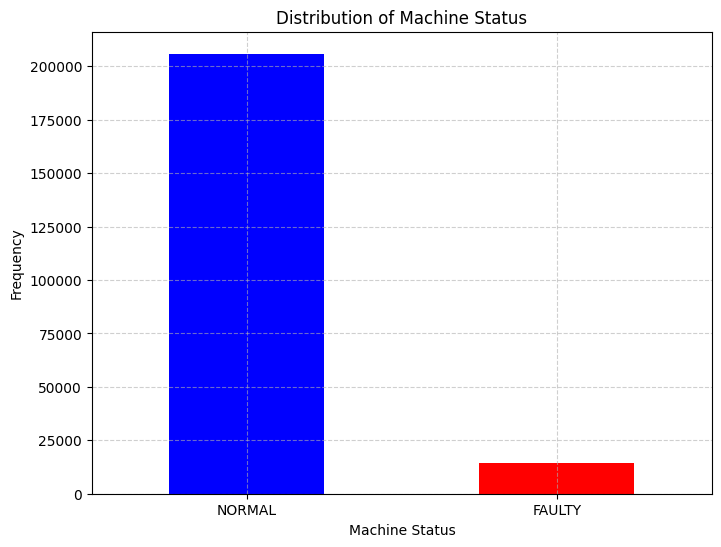

In [68]:
# Count the occurrences of each class
status_counts = data_cleaned['machine_status'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
status_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Machine Status')
plt.xlabel('Machine Status')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['NORMAL', 'FAULTY'], rotation=0)  # Adjust labels accordingly
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

C:\Users\user\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


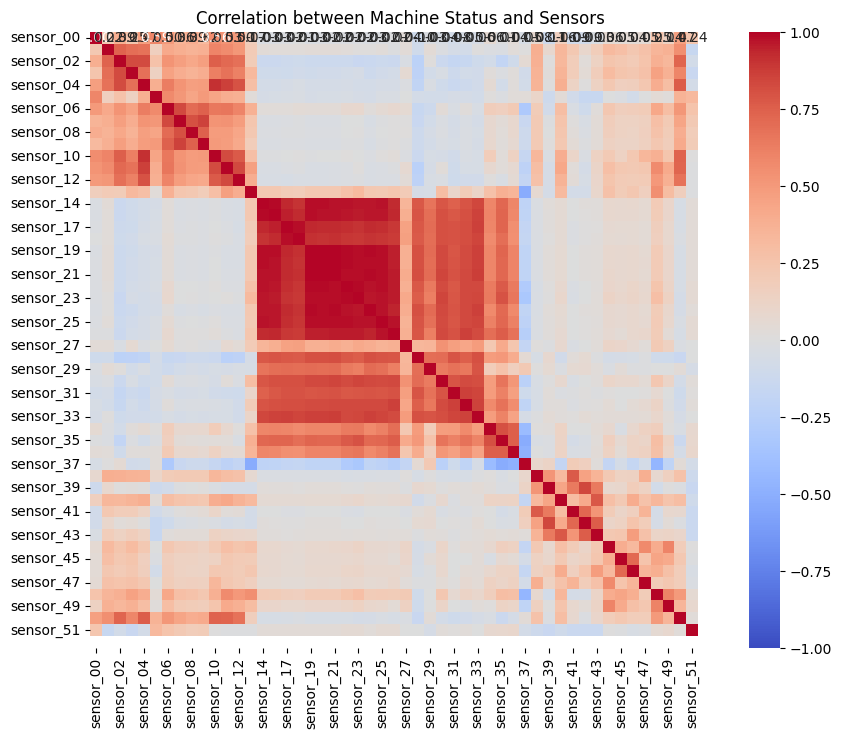

In [71]:
# Assuming the correlation matrix calculation is correct
correlation_matrix = data_cleaned.corr()

# Create a heatmap with custom annotations handling
plt.figure(figsize=(10, 8))
ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, cbar=True)
plt.title('Correlation between Machine Status and Sensors')

# Improve annotation handling by providing a custom formatter due to error
for text in ax.texts:
    try:
        t = float(text.get_text())
        text.set_text(f"{t:.2f}")
    except ValueError:
        text.set_text('')  

plt.show()

In [6]:
# Split the data into features and target
X = data_cleaned.drop('machine_status', axis=1)
y = data_cleaned['machine_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the distribution of the target variable in the training set
print(y_train.value_counts(normalize=True))

machine_status
0    0.93426
1    0.06574
Name: proportion, dtype: float64


In [12]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate

# Create a balanced random forest classifier
brf_model = BalancedRandomForestClassifier(n_estimators=100, sampling_strategy='all', replacement=True, random_state=42)

# Define evaluation metrics
scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1'}

# Perform cross-validation
cv_results = cross_validate(brf_model, X_train, y_train, cv=5, scoring=scoring)

# Print mean scores for each metric
for metric in scoring:
    mean_score = cv_results['test_' + metric].mean()
    print(f"Mean {metric}:", mean_score)

# Fit the model on the entire training data
brf_model.fit(X_train, y_train)

# Generate predictions on the testing data
brf_predictions = brf_model.predict(X_test)

# Evaluate the performance of the balanced random forest model using accuracy
brf_accuracy = accuracy_score(y_test, brf_predictions)
print("Accuracy of Balanced Random Forest:", brf_accuracy)

# Compute precision, recall, and F1-score on the testing data
brf_precision = precision_score(y_test, brf_predictions)
brf_recall = recall_score(y_test, brf_predictions)
brf_f1 = f1_score(y_test, brf_predictions)

print("Precision of Balanced Random Forest:", brf_precision)
print("Recall of Balanced Random Forest:", brf_recall)
print("F1-score of Balanced Random Forest:", brf_f1)

C:\Users\user\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\user\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\user\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\User

Mean accuracy: 0.9978440434156999
Mean precision: 0.9688023268237
Mean recall: 0.9993958821078252
Mean f1: 0.9838591655615382


C:\Users\user\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\user\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Accuracy of Balanced Random Forest: 0.9985475671750181
Precision of Balanced Random Forest: 0.9787090233186887
Recall of Balanced Random Forest: 0.9996548153261995
F1-score of Balanced Random Forest: 0.9890710382513661


In [18]:
# Base classifiers for ensemble methods
logistic_reg = LogisticRegression(random_state=42, solver='saga',max_iter=1000)
decision_tree = DecisionTreeClassifier(random_state=42)
knn = KNeighborsClassifier()

In [19]:
# Voting Classifier
voting_clf = VotingClassifier(estimators=[('lr', logistic_reg), ('dt', decision_tree), ('knn', knn)], voting='hard')
voting_clf.fit(X_train, y_train)
voting_clf_accuracy = accuracy_score(y_test, voting_clf.predict(X_test))
print("Accuracy of Voting Classifier:", voting_clf_accuracy)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy of Voting Classifier: 0.9997730573710966


In [21]:
# Bagging (Bootstrap Aggregating) with Decision Trees
bagging_dt = BaggingClassifier(estimator=decision_tree, n_estimators=100, random_state=42)
bagging_dt.fit(X_train, y_train)
bagging_dt_accuracy = accuracy_score(y_test, bagging_dt.predict(X_test))
print("Accuracy of Bagging with Decision Trees:", bagging_dt_accuracy)

Accuracy of Bagging with Decision Trees: 0.9998865286855483


In [23]:
# Boosting with AdaBoost
adaboost = AdaBoostClassifier(estimator=decision_tree, n_estimators=100, random_state=42)
adaboost.fit(X_train, y_train)
adaboost_accuracy = accuracy_score(y_test, adaboost.predict(X_test))
print("Accuracy of AdaBoost:", adaboost_accuracy)

Accuracy of AdaBoost: 0.9998411401597677


In [25]:
# Create the estimators for stacking
logistic_reg = LogisticRegression(max_iter=1000, solver='saga')  # Increase max_iter
decision_tree = DecisionTreeClassifier()
knn = KNeighborsClassifier()

estimators = [
    ('lr', logistic_reg),
    ('dt', decision_tree),
    ('knn', knn)
]

# Using StandardScaler to scale the features
stacking_clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
)

# Fit the model
stacking_clf.fit(X_train, y_train)

# Predict and calculate accuracy
stacking_clf_accuracy = accuracy_score(y_test, stacking_clf.predict(X_test))
print("Accuracy of Stacking Classifier:", stacking_clf_accuracy)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was re

Accuracy of Stacking Classifier: 0.9998411401597677


In [27]:
# Voting Classifier
voting_cv_scores = cross_val_score(voting_clf, X, y, cv=5)
print("CV Accuracy for Voting Classifier:", np.mean(voting_cv_scores))

# Bagging with Decision Trees
bagging_dt_cv_scores = cross_val_score(bagging_dt, X, y, cv=5)
print("CV Accuracy for Bagging with Decision Trees:", np.mean(bagging_dt_cv_scores))

# AdaBoost
adaboost_cv_scores = cross_val_score(adaboost, X, y, cv=5)
print("CV Accuracy for AdaBoost:", np.mean(adaboost_cv_scores))

# Stacking Classifier
stacking_clf_cv_scores = cross_val_score(stacking_clf, X, y, cv=5)
print("CV Accuracy for Stacking Classifier:", np.mean(stacking_clf_cv_scores))

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


CV Accuracy for Voting Classifier: 0.98310639070443
CV Accuracy for Bagging with Decision Trees: 0.9907815904139433
CV Accuracy for AdaBoost: 0.9882489106753812


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was re

CV Accuracy for Stacking Classifier: 0.9879448075526508


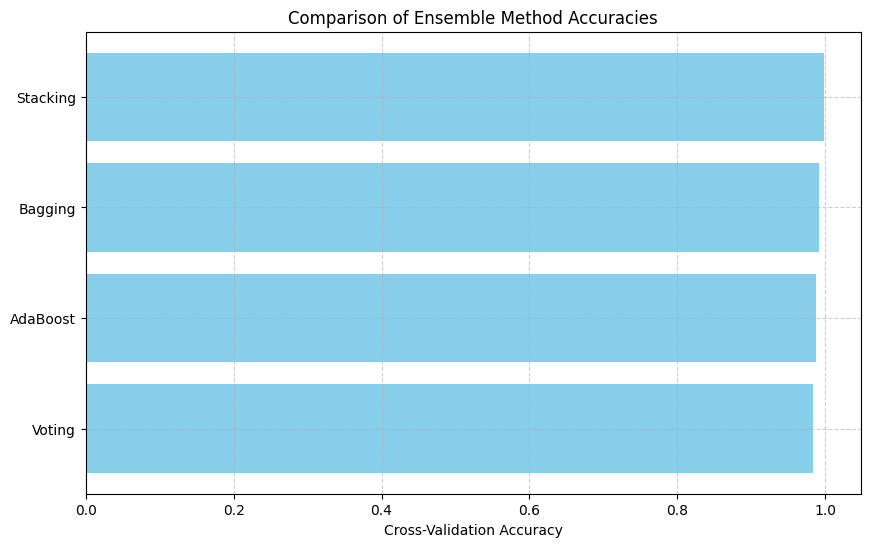

In [29]:
# Assume these are the average CV accuracy scores obtained from cross_val_score for each classifier
model_names = ['Voting', 'Bagging', 'AdaBoost', 'Stacking']
accuracy_scores = [0.983, 0.991, 0.988, 0.998]  # scores

# Sorting the scores and corresponding model names in ascending order
sorted_indices = np.argsort(accuracy_scores)
sorted_scores = np.array(accuracy_scores)[sorted_indices]
sorted_models = np.array(model_names)[sorted_indices]

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.barh(sorted_models, sorted_scores, color='skyblue')
plt.xlabel('Cross-Validation Accuracy')
plt.title('Comparison of Ensemble Method Accuracies')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

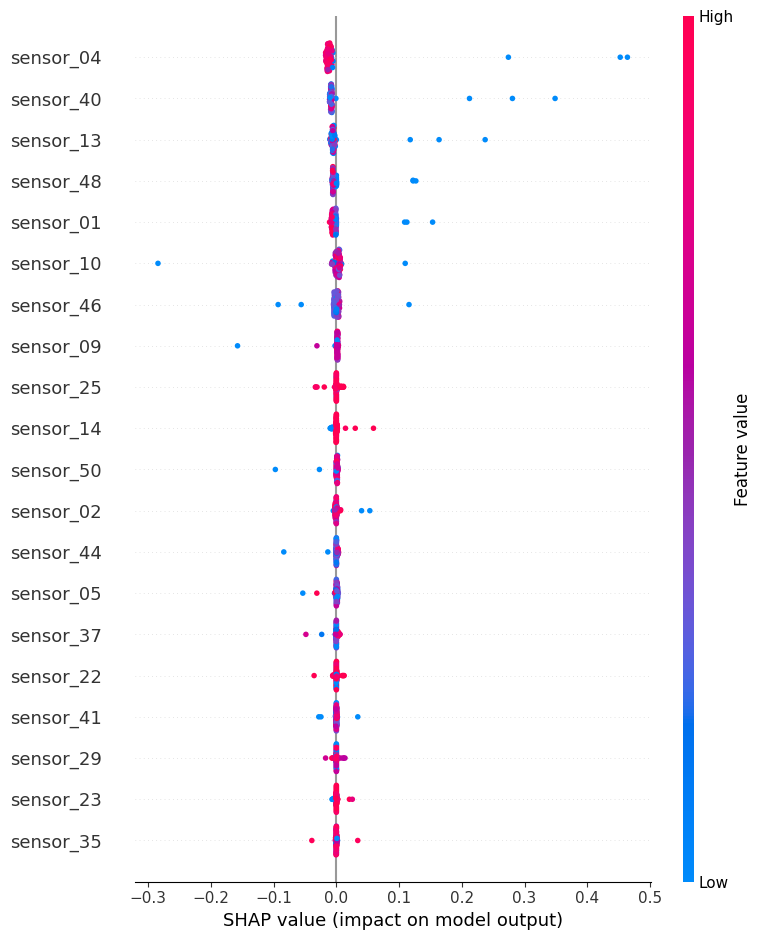

In [39]:
X_sample = shap.sample(X_train, 100)  # Take a sample of the training data to speed up the process

explainer = shap.KernelExplainer(adaboost.predict, X_sample)
shap_values = explainer.shap_values(X_sample)

# Plotting the summary plot for the SHAP values
shap.summary_plot(shap_values, X_sample, feature_names=X.columns)

In [53]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the distribution of the target variable in the training set
print(y_train.value_counts(normalize=True))

machine_status
0    0.93426
1    0.06574
Name: proportion, dtype: float64


Epoch 1/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9595 - loss: 0.8936 - val_accuracy: 0.9888 - val_loss: 0.0582
Epoch 2/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9906 - loss: 0.0337 - val_accuracy: 0.9906 - val_loss: 0.0295
Epoch 3/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9914 - loss: 0.0328 - val_accuracy: 0.9946 - val_loss: 0.0186
Epoch 4/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9922 - loss: 0.0238 - val_accuracy: 0.9943 - val_loss: 0.0214
Epoch 5/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9925 - loss: 0.0213 - val_accuracy: 0.9904 - val_loss: 0.0391
Epoch 6/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9930 - loss: 0.0219 - val_accuracy: 0.9947 - val_loss: 0.0207
Epoch 7/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9939 - loss: 0.0202 - val_accuracy: 0.9952 - val_loss: 0.0179
Epoch 8/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9943 - loss: 0.0175 - 

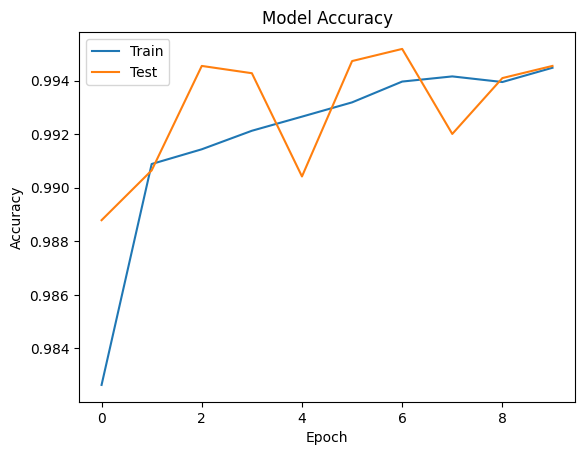

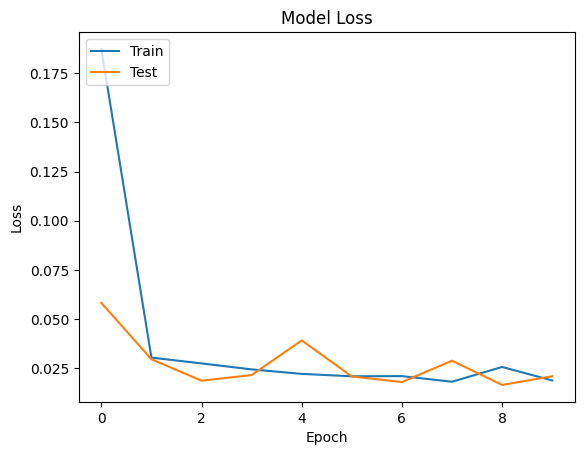

In [54]:
# Ensure data indices are reset for consistency
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

class_weight_dict = dict(enumerate(class_weights))
# Calculate class weights for handling class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Build the model architecture
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Specify input shape explicitly
    Dense(32, activation='relu'),  # First hidden layer with 32 neurons and ReLU activation
    Dense(16, activation='relu'),  # Second hidden layer with 16 neurons and ReLU activation
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model with the Adam optimizer and binary cross-entropy loss function
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the full dataset
history = model.fit(X_train, y_train, epochs=10, batch_size=32, class_weight=class_weight_dict, validation_data=(X_test, y_test))

# Plotting training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


1377/1377 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step
Precision: 0.9246
Recall: 0.9986
F1 Score: 0.9602
ROC AUC Score: 0.9998


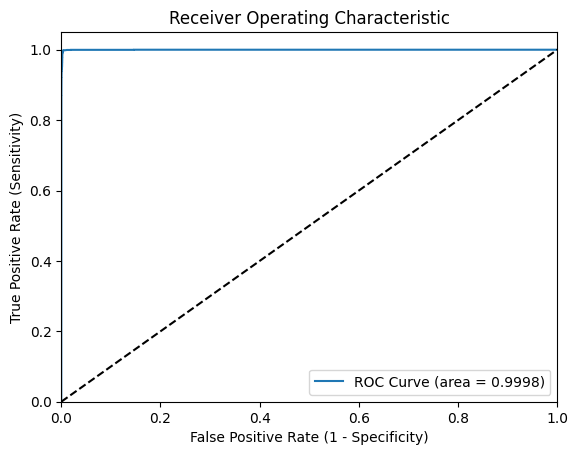

In [55]:
# Predict probabilities for the test set
y_probs = model.predict(X_test)
# Use threshold of 0.5 for binary classification
y_pred = (y_probs >= 0.5).astype('int')

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_probs)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [58]:
# Define the learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Add it to the callbacks list for fitting
callbacks_list = [reduce_lr]

# Fit the model with the learning rate scheduler callback
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_test, y_test),
                    callbacks=[reduce_lr])

Epoch 1/50
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 0.9978 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 2/50
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9993 - loss: 0.0039 - val_accuracy: 0.9990 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 3/50
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9993 - loss: 0.0028 - val_accuracy: 0.9996 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 4/50
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9992 - loss: 0.0034 - val_accuracy: 0.9995 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 5/50
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9994 - loss: 0.0025 - val_accuracy: 0.9984 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 6/50
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9993 - loss: 0.0030 - val_accuracy: 0.9994 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 7/50
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9992 - 

In [62]:
# Set the number of folds for KFold cross-validation
num_folds = 5
# Initialize the KFold utility with the specified number of splits, shuffling before splitting
kfold = KFold(n_splits=num_folds, shuffle=True)

# Prepare empty lists to record the training history and evaluation scores for each fold
history_list = []
scores_per_fold = []

# Start the cross-validation process
fold_no = 1  # Initialize fold counter
for train, test in kfold.split(X, y):
    # Clear the previous model session to start afresh for each fold
    clear_session()

    # Define the structure of the Sequential model
    model = Sequential([
        Input(shape=(X.shape[1],)),  # Set input shape to match the number of features in X
        Dense(32, activation='relu'),  # First dense layer with 32 neurons and ReLU activation
        Dense(16, activation='relu'),  # Second dense layer with 16 neurons and ReLU activation
        Dense(1, activation='sigmoid')  # Output layer with 1 neuron and sigmoid activation for binary classification
    ])
    
    # Compile the model with the Adam optimizer, binary cross-entropy loss, and accuracy as the metric
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Output a message indicating which fold is being trained
    print(f'Training for fold {fold_no} ...')

    # Train the model on the current fold's training data
    history = model.fit(X.iloc[train], y.iloc[train],
                        batch_size=32,
                        epochs=10,
                        validation_data=(X.iloc[test], y.iloc[test]))
    
    # Save the training history in the history_list
    history_list.append(history)
    # Evaluate the model on the current fold's test data and save the scores
    scores_per_fold.append(model.evaluate(X.iloc[test], y.iloc[test], verbose=0))

    # Increment the fold counter
    fold_no += 1

# Calculate the average and standard deviation of evaluation scores across all folds
average_scores = np.mean(scores_per_fold, axis=0)
stddev_scores = np.std(scores_per_fold, axis=0)

# Output the average scores and the standard deviation for each metric across all folds
print(f"Average scores across all folds: {average_scores}")
print(f"Standard deviation across all folds: {stddev_scores}")

Training for fold 1 ...
Epoch 1/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9842 - loss: 0.5384 - val_accuracy: 0.9948 - val_loss: 0.0737
Epoch 2/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9926 - loss: 0.0639 - val_accuracy: 0.9960 - val_loss: 0.0121
Epoch 3/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9938 - loss: 0.0191 - val_accuracy: 0.9938 - val_loss: 0.0205
Epoch 4/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9946 - loss: 0.0147 - val_accuracy: 0.9966 - val_loss: 0.0089
Epoch 5/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9954 - loss: 0.0125 - val_accuracy: 0.9949 - val_loss: 0.0131
Epoch 6/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9961 - loss: 0.0106 - val_accuracy: 0.9966 - val_loss: 0.0087
Epoch 7/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9964 - loss: 0.0105 - val_accuracy: 0.9974 - val_loss: 0.0071
Epoch 8/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accur

In [63]:
# Calculate average and standard deviation of accuracy and loss over epochs
average_accuracy_per_epoch = np.mean([history.history['val_accuracy'] for history in history_list], axis=0)
stddev_accuracy_per_epoch = np.std([history.history['val_accuracy'] for history in history_list], axis=0)

average_loss_per_epoch = np.mean([history.history['val_loss'] for history in history_list], axis=0)
stddev_loss_per_epoch = np.std([history.history['val_loss'] for history in history_list], axis=0)

print(f"Average validation accuracy per epoch: {average_accuracy_per_epoch}")
print(f"Average validation loss per epoch: {average_loss_per_epoch}")


Average validation accuracy per epoch: [0.99241558 0.99192538 0.99248819 0.9957698  0.99548384 0.99619191
 0.99647784 0.99631445 0.99656862 0.99687726]
Average validation loss per epoch: [0.06534739 0.0258494  0.0315054  0.01119607 0.01133514 0.01046431
 0.00890614 0.00904295 0.00926694 0.00729034]


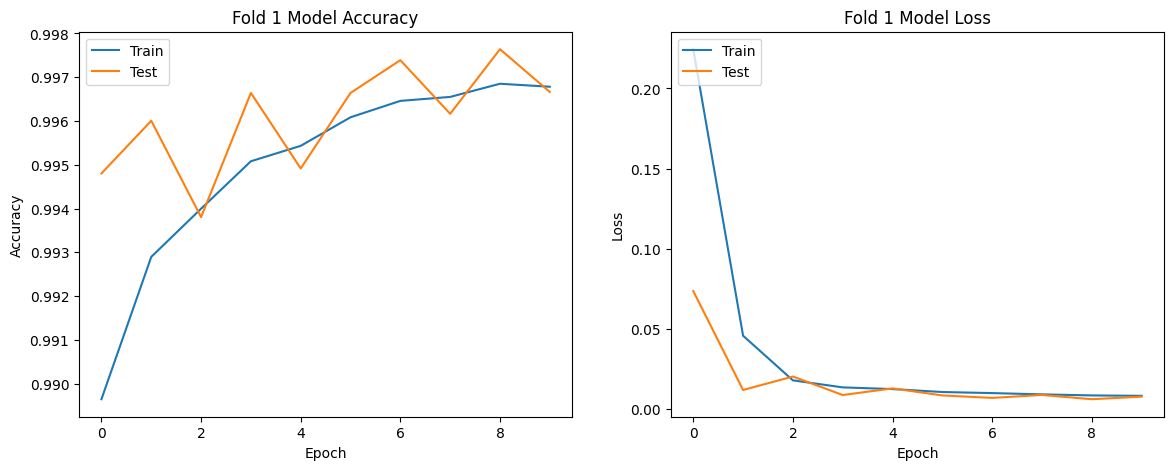

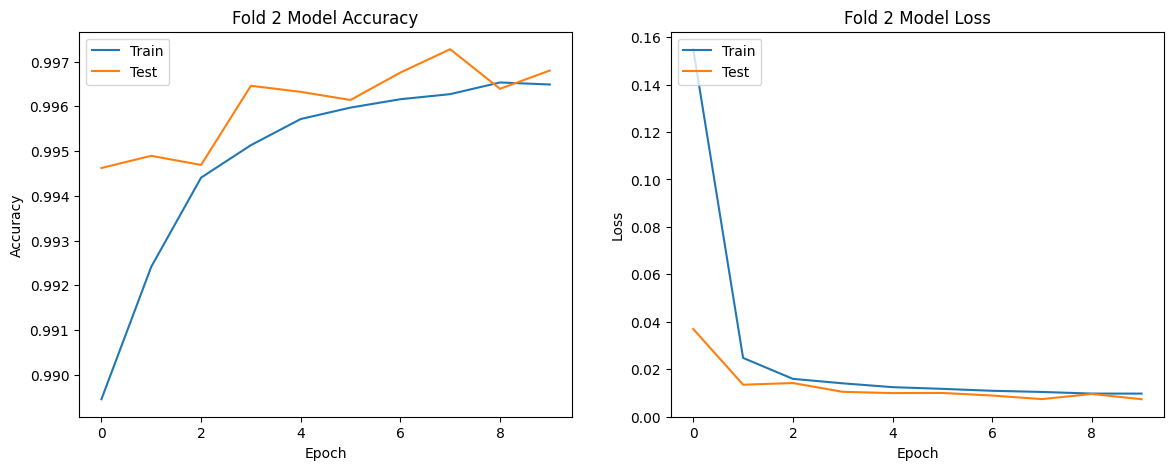

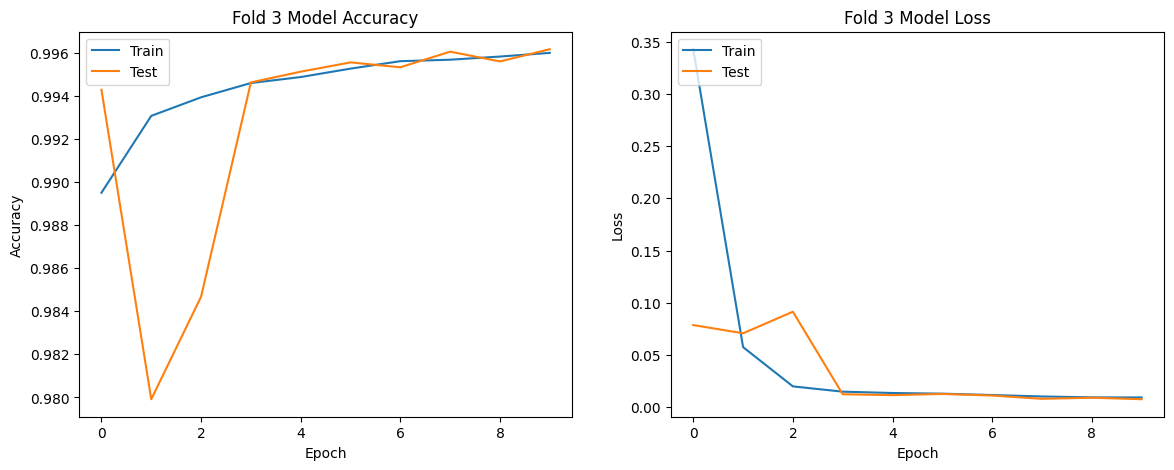

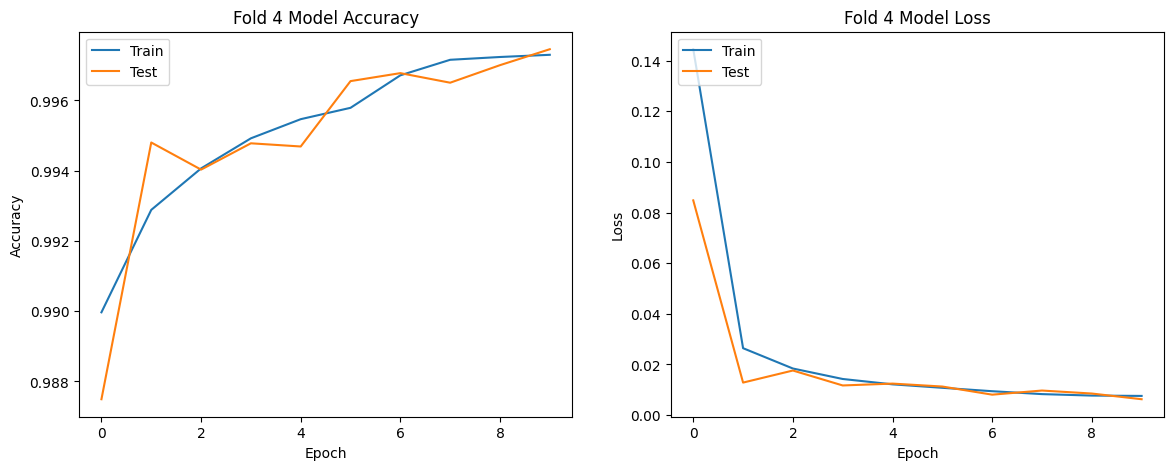

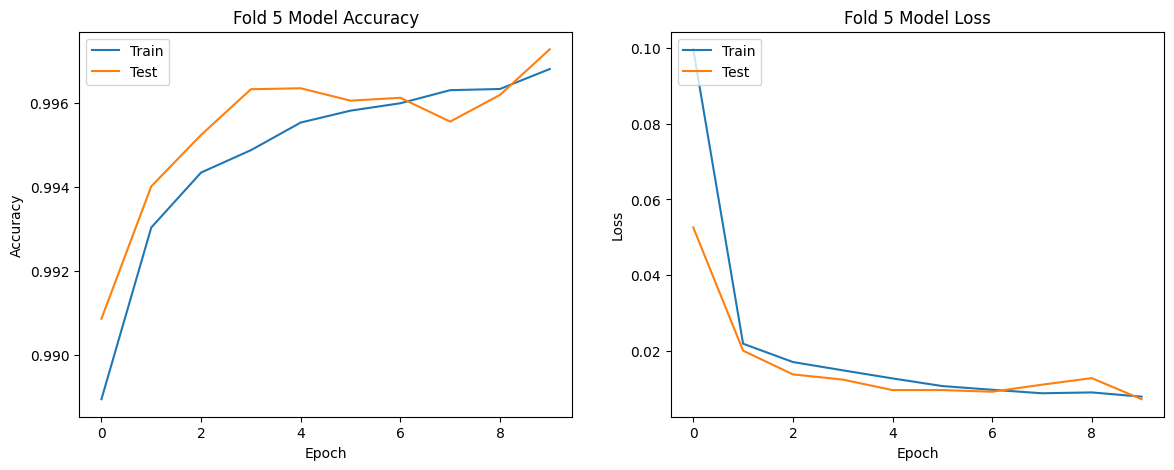

In [64]:
accuracy_per_fold = []
loss_per_fold = []

# Iterate through each fold's history and plot
for i, history in enumerate(history_list):
    plt.figure(figsize=(14, 5))

    # Summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Fold {i+1} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Fold {i+1} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Save per fold result
    accuracy_per_fold.append(history.history['val_accuracy'])
    loss_per_fold.append(history.history['val_loss'])

    plt.show()


Epoch 1/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9882 - loss: 0.3451
Epoch 2/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9923 - loss: 0.0413
Epoch 3/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9928 - loss: 0.0217
Epoch 4/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9939 - loss: 0.0169
Epoch 5/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9948 - loss: 0.0149
Epoch 6/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9955 - loss: 0.0116
Epoch 7/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9956 - loss: 0.0110
Epoch 8/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9958 - loss: 0.0100
Epoch 9/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9958 - loss: 0.0104
Epoch 10/10
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9959 - loss: 0.0098
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


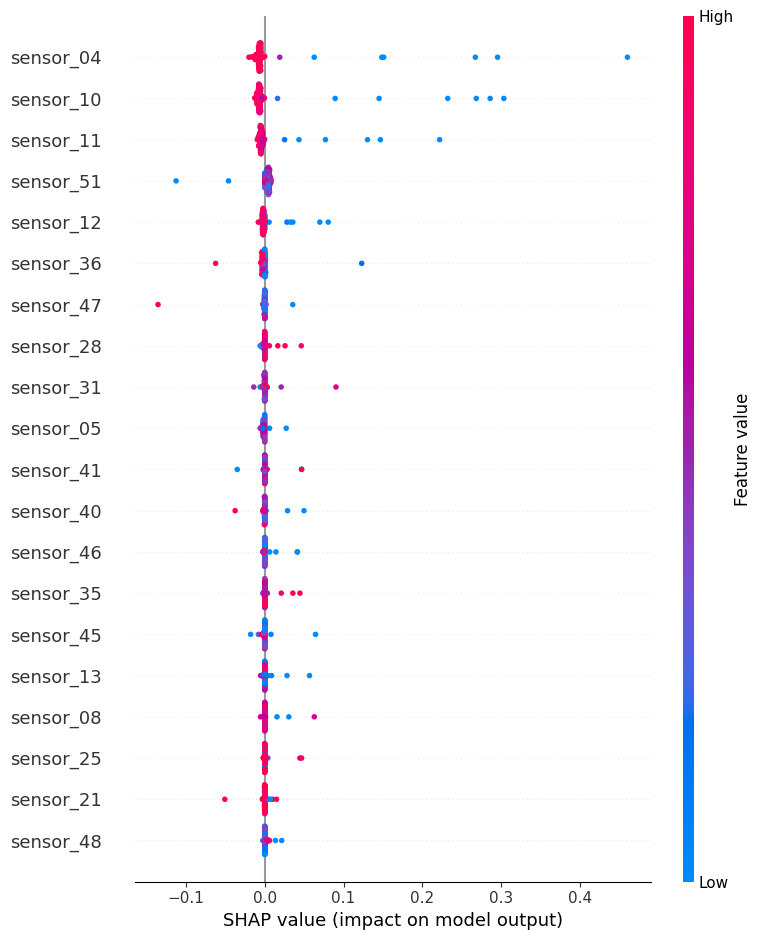

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [83]:
# Retrain the model on the entire dataset for SHAP analysis
clear_session()
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=10)

# Convert the test dataset to NumPy array as KernelExplainer can work directly with arrays or DataFrames
X_test_np = X_test.iloc[:100].to_numpy()

# background dataset
background = shap.sample(X_train, 50).to_numpy()  

# Initialize KernelExplainer with the model prediction function and the background dataset
explainer = shap.KernelExplainer(model.predict, background)

# Reshape shap_values to remove the extra dimension
reshaped_shap_values = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])

# Now try the summary plot again with the reshaped SHAP values
try:
    shap.summary_plot(reshaped_shap_values, X_test.iloc[:100].to_numpy(), feature_names=X_test.columns.tolist())
except Exception as e:
    print("Error after reshaping SHAP values:", e)

# For a single prediction
instance_to_explain = X_test.iloc[0:1].to_numpy()
shap_values_instance = explainer.shap_values(instance_to_explain)